In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
%matplotlib inline
import matplotlib
from scipy.io import loadmat
from os.path import basename
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from pymr.heart import ahaseg

In [3]:
import nibabel
heart = nibabel.load(r"/home/OpenDataset/Testing/A5D0G0/A5D0G0_sa_gt.nii.gz").get_fdata()

In [4]:
import pymr.heart as pyheart

/home/OpenDataset/Testing/A1K2P5/A1K2P5_sa_gt.nii.gz
[ 0  0  0 11  1  1  2  2  2  3  3  4  0  0]
/home/OpenDataset/Testing/A2H5K9/A2H5K9_sa_gt.nii.gz
[ 0  4  3  2  2  1  1 11 11 11]
/home/OpenDataset/Testing/A2L1N6/A2L1N6_sa_gt.nii.gz
[ 0  0  0  4  3  2  2  1  1 11 11  0  0]
/home/OpenDataset/Testing/A3H5R1/A3H5R1_sa_gt.nii.gz
[ 0  0 11 11  1  2  2  3  4  0  0  0]
/home/OpenDataset/Testing/A3P9V7/A3P9V7_sa_gt.nii.gz
[ 0 11  1  1  2  2  3  3  4  0  0  0]
/home/OpenDataset/Testing/A4A8V9/A4A8V9_sa_gt.nii.gz
[ 0  4  4  3  3  2  2  1  1 11 11  0]
/home/OpenDataset/Testing/A4B9O6/A4B9O6_sa_gt.nii.gz
[ 0  0  4  3  2  2  1  1 11 11  0]
/home/OpenDataset/Testing/A4K8R4/A4K8R4_sa_gt.nii.gz
[ 0 11 11  1  1  2  2  3  3  4  0  4]
/home/OpenDataset/Testing/A4R4T0/A4R4T0_sa_gt.nii.gz
[ 0  4  4  3  2  2  1 11  0  0]


ValueError: attempt to get argmin of an empty sequence

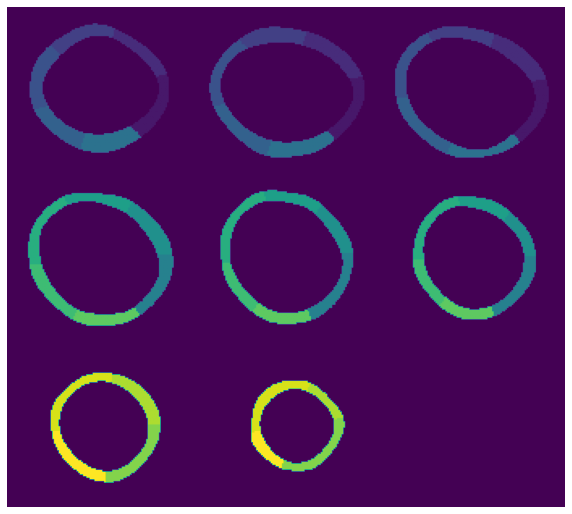

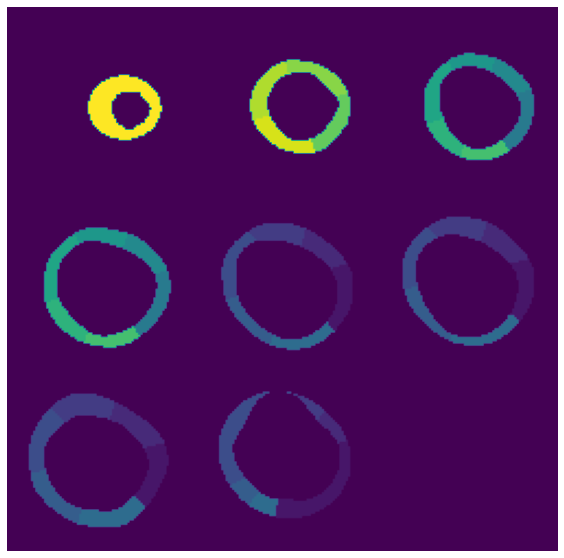

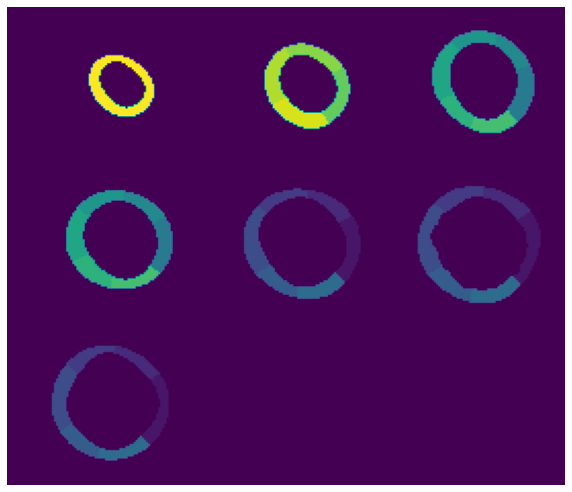

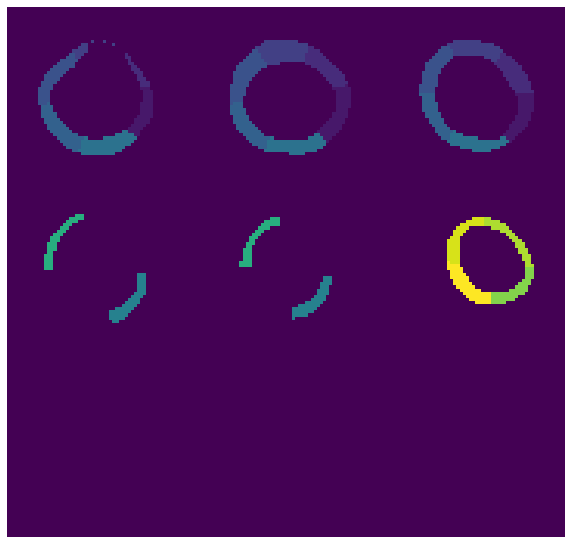

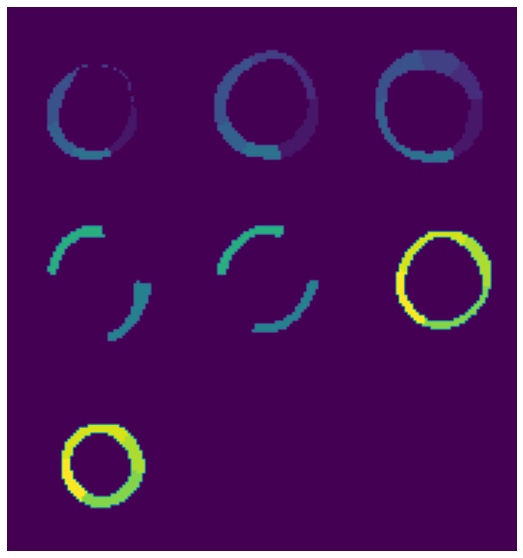

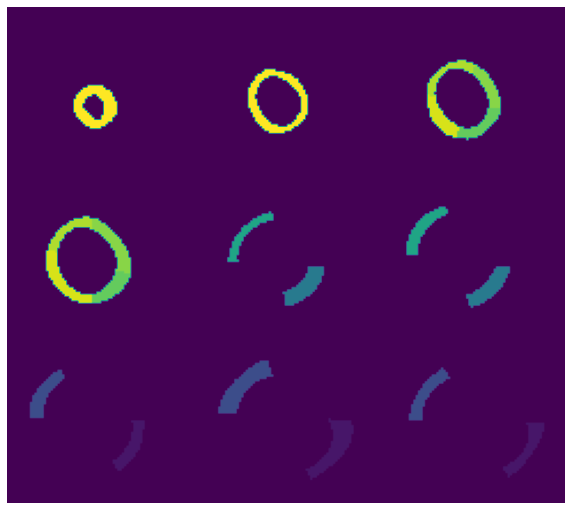

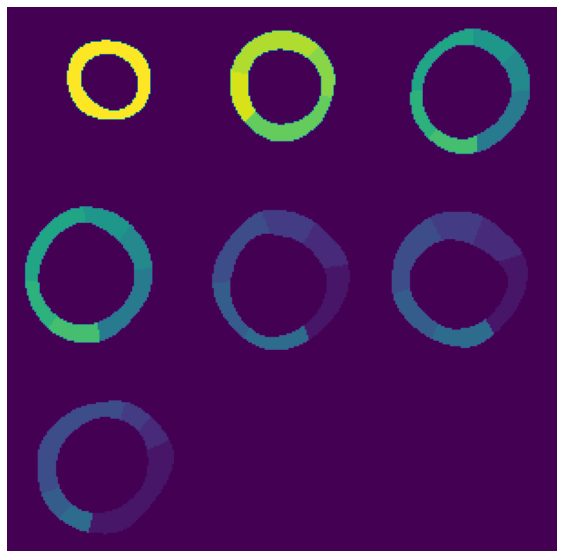

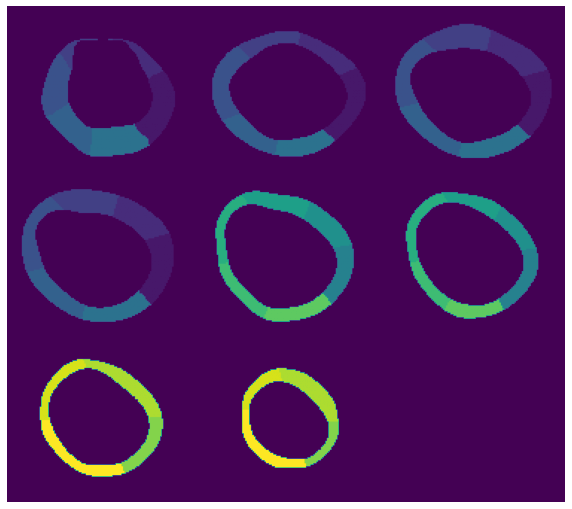

In [5]:
import glob
for f in glob.glob(r'/home/OpenDataset/Testing/**/*gt.nii.gz')[:10]:
    print(f)
    heart = nibabel.load(f).get_fdata()
    heart_aha17_4d = pyheart.data_converter.convert(heart)
    sys_frame, dia_frame = pyheart.get_frame(heart)
    heart_crop, _ = pyheart.auto_crop(heart_aha17_4d)
    pyheart.montage(heart_crop[..., dia_frame])

In [ ]:
maxv = y2.argsort()[::-1][:10]
maxv = maxv[np.argmin(maxv-360*3//2)]

In [ ]:
for ii in range(heart.shape[2]):
    result = pyheart.thickness.thick_ana_xyt(heart[..., ii, :])

In [ ]:
pyheart.get_frame(heart)

In [ ]:
from pymr.heart.cine import get_frame
from pymr.heart.data_converter import get_slice_label
f = heart
result_dir = None
if isinstance(f, str):
    temp = nibabel.load(f)
    heart = temp.get_fdata()
    affine = temp.affine
    file_input = True
else:
    heart = f.copy()
    file_input = False

slice_label = get_slice_label(heart)
#print(slice_label)
offset = dict()
offset[1] = 0
offset[2] = 6
offset[3] = 12

count = -1
heart_aha17_4d = heart  * 0
for ii in range(slice_label.size):
    #print(ii)
    #print(slice_label[ii])
    count = count + 1
    if (slice_label[ii] == 0) or (slice_label[ii] == 11):
        continue

    if slice_label[ii] == 4:
        temp = heart[:, :, ii, :].copy()
        temp[temp==2] = 17
        temp[temp==1] = 0
        temp[temp==3] = 0
        heart_aha17_4d[:, :, ii, :] = temp
        continue


    heart_xyt = heart[:, :, ii, :].copy()

    sys_frame, dia_frame = get_frame(heart_xyt)

    #print(dia_frame, sys_frame)
    heart_xy_dia = heart_xyt[..., dia_frame]
    heart_xy_sys = heart_xyt[..., sys_frame]
    if slice_label[ii] == 3:
        nseg = 4
    else:
        nseg = 6


    dia_seg = ahaseg.get_seg(heart_xy_dia, nseg)
    sys_seg = ahaseg.get_seg(heart_xy_sys, nseg)

    dia_seg[dia_seg > 0] = dia_seg[dia_seg > 0] + offset[slice_label[ii]]
    sys_seg[sys_seg > 0] = sys_seg[sys_seg > 0] + offset[slice_label[ii]]

    heart_aha17_4d[:, :, ii, dia_frame] = dia_seg
    heart_aha17_4d[:, :, ii, sys_frame] = sys_seg


#=====================process basal
go = True
slice_label_temp = slice_label.copy()
while go:
    if np.any(np.diff(slice_label_temp)==-10):
        index11 = int(np.where(np.diff(slice_label_temp)==-10)[0])
        index1 = index11 + 1
        slice_label_temp[index11] = 1
        go = True

    elif np.any(np.diff(slice_label_temp)==10):
        index11 = int(np.where(np.diff(slice_label_temp)==10)[0] + 1)
        index1 = index11 - 1
        slice_label_temp[index11] = 1
        go = True
    else:
        index11 = -1
        go = False

    if go:
        mask11_sys = heart[:, :, index11, sys_frame]
        mask11_dia = heart[:, :, index11, dia_frame]
        seg1_sys = heart_aha17_4d[:, :, index1, sys_frame]
        seg1_dia = heart_aha17_4d[:, :, index1, dia_frame]

        seg11_dia = proc_basal_without_RV(seg1_dia, mask11_dia)
        seg11_sys = proc_basal_without_RV(seg1_sys, mask11_sys)
        heart_aha17_4d[:, :, index11, sys_frame] = seg11_sys
        heart_aha17_4d[:, :, index11, dia_frame] = seg11_dia
        #plt.figure()
        #plt.imshow(seg11)
        #print(slice_label_temp)  



if (result_dir is not None) and file_input:        
    result_f = join(result_dir, basename(f))        
    nii_label = nibabel.Nifti1Image(heart_aha17_4d.astype(np.uint8), affine)
    nibabel.save(nii_label, result_f)




In [ ]:
print(slice_label[ii])
plt.imshow(heart_xy_sys)


In [ ]:
#sys_seg = ahaseg.get_seg(heart_xy_sys, nseg)

sys_seg = ahaseg.get_angle(heart_xy_sys, nseg)

In [ ]:
LVbmask, LVwmask, RVbmask = ahaseg.get_heartmask(heart_xy_sys)
#import time
#t = time.time()
sweep360 = ahaseg.get_sweep360(LVwmask, RVbmask)

In [ ]:
from scipy.optimize import curve_fit
from scipy.signal import medfilt
sumar = np.array(sweep360)
x = np.arange(sumar.size)
y = sumar
maxv = np.argmax(y)
y = medfilt(y)

In [ ]:
plt.plot(np.hstack([y, y, y]))

In [ ]:
y2 = np.hstack([y, y, y])
y2 = medfilt(y2)
maxv = int(np.median(y2.argsort()[::-1][:3]))
y2[:(maxv-90)] = 0
y2[(maxv+90):] = 0
x = np.arange(y2.size)

In [ ]:
plt.plot(y2)

In [ ]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def fit(x, y):
    p0 = [np.max(y), np.argmax(y)+x[0], 1.]
    try:
        coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
        A, mu, sigma = coeff
    except:
        mu = 0
        sigma = 0
    return mu, sigma

In [ ]:
def get_theta(sweep360):
    from scipy.optimize import curve_fit
    from scipy.signal import medfilt
    
    y = sweep360.copy()
    
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    def fit(x, y):
        p0 = [np.max(y), np.argmax(y)+x[0], 1.]
        try:
            coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
            A, mu, sigma = coeff
        except:
            mu = 0
            sigma = 0
        return mu, sigma
    
    y2 = np.hstack([y, y, y])
    y2 = medfilt(y2)
    maxv = int(np.median(y2.argsort()[::-1][:3]))
    y2[:(maxv-90)] = 0
    y2[(maxv+90):] = 0
    x = np.arange(y2.size)
    mu, sigma = fit(x[(maxv-90):maxv], y2[(maxv-90):maxv])
    uprank1 = mu - sigma*2.5
    mu, sigma = fit(x[maxv:(maxv+90)], y2[maxv:(maxv+90)])
    downrank1 = mu + sigma*2.5
    uprank2 = np.nonzero(y2 > 5)[0][0]
    downrank2 = np.nonzero(y2 > 5)[0][-1]
    uprank = int(max(uprank1, uprank2)) % 360
    downrank = int(min(downrank1, downrank2)) % 360
    return uprank, downrank

In [ ]:
get_theta(sweep360)

In [ ]:
uprank, downrank

In [ ]:
def proc_basal_without_RV(mask1, mask5):
    if np.unique(mask5).sum() == 6:
        seg = ahaseg.get_seg(mask5, nseg=6)
        return seg
    
    # find nearest point with ahaseg
    xx5, yy5 = np.nonzero(mask5==2)
    xx1, yy1 = np.nonzero(mask1)
    seg5 = mask5 * 0
    for ii in range(xx5.size):
        index = np.sqrt((xx1 - xx5[ii])**2 + (yy1 - yy5[ii])**2).argmin()
        seg5[xx5[ii], yy5[ii]] = mask1[xx1[index], yy1[index]]
    return seg5

In [ ]:
go = True
slice_label_temp = slice_label.copy()
while go:
    if np.any(np.diff(slice_label_temp)==-10):
        index11 = int(np.where(np.diff(slice_label)==-10)[0])
        index1 = index11 + 1
        slice_label_temp[index11] = 1
        go = True

    elif np.any(np.diff(slice_label_temp)==10):
        index11 = int(np.where(np.diff(slice_label)==10)[0] + 1)
        index1 = index11 - 1
        slice_label_temp[index11] = 1
        go = True
    else:
        index11 = -1
        go = False
    
    if go:
        mask11_sys = heart[:, :, index11, sys_frame]
        mask11_dia = heart[:, :, index11, dia_frame]
        seg1_sys = heart_aha17_4d[:, :, index1, sys_frame]
        seg1_dia = heart_aha17_4d[:, :, index1, dia_frame]

        seg11 = proc_basal_without_RV(seg1_dia, mask11_dia)
        #plt.figure()
        #plt.imshow(seg11)
        print(slice_label_temp)

In [ ]:
mask1[xx1[46], yy1[46]]

In [ ]:
mask11_sys.squeeze().shape

In [ ]:
heart[:, :, 1, 1].shape

In [ ]:
diff = np.diff(np.sum(heart==1, axis=(0, 1, 3))) * curve_and[1:]
diff = np.median(diff[curve_and[1:] > 0])

if diff > 0:
    basal_first = True
else:
    base_first = False

In [ ]:
int(np.array([1]))

In [ ]:
heart_crop, _ = pyheart.auto_crop(heart)
pyheart.montage(heart_crop[..., sys_frame])

In [ ]:
heart.shape

In [ ]:
heart_crop, crop = pyheart.auto_crop(heart)
motion_map_list = []
for ii in range(heart_crop.shape[2]):
    print(ii)
    heart_mask = heart_crop[..., ii, :]
    motion_vector, motion_map = pyheart.motion.motion_ana_xyt(heart_mask, nseg=6, display=True)
    if np.sum(motion_map)==0:
        continue
    motion_map_list.append(motion_map)

plt.figure(figsize=(30,5))
plt.imshow(np.hstack(motion_map_list))
plt.axis('off')
